In this notebook, I try using the EDGES analysis technique on a simulated signal that is not symmetric but using the EDGES signal model (which is forced to be symmetric) to see if their technique is biased towards a surprising and unphysical shape. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import corner
sys.path.append(os.path.abspath('../src/'))
import global_signal_black_holes_mcmc as GSBH_MCMC
import global_signal_black_holes as GSBH
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'stix'
#matplotlib.rcParams['font.family'] = 'STIXGeneral'
#matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

First I initialize a sampler, plot the data, and perform sampling.

{'NU0': 73.21865676798339, 'TAU': 4.323004732386623, 'A': 0.5215484623046568, 'W': 31.372511887959703, 'NPOLY': 5, 'APOLY0': 1872.8639303733428, 'APOLY1': -283.650417543293, 'APOLY2': 442.8488611415504, 'APOLY3': -322.24474770655905, 'APOLY4': 85.20432106859397}


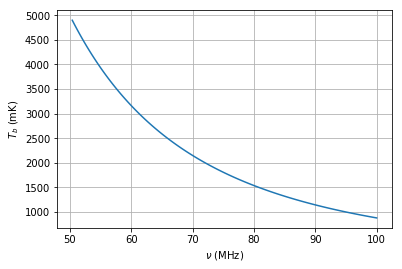

In [2]:
CONFIG='../config/analytic_test_blackhole_injection.yaml'
sampler=GSBH_MCMC.Sampler(CONFIG,fmin=50.,fmax=100)#initialize sampler
plt.plot(sampler.freqs,sampler.tb_meas)#plot simulated data 
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('$T_b$ (mK)')
plt.grid()
sampler.sample()#perform sampling
samples=sampler.sampler.chain[:, sampler.config['NBURN']:, :].reshape((-1, len(sampler.params_vary)))
ml_samples=np.median(samples,axis=0)

In [3]:
print(ml_samples)

[ 7.31569598e+01  4.44127212e+00  5.06516825e-01  3.15774600e+01
  1.87154949e+03 -2.78043259e+02  4.34141785e+02 -3.16399136e+02
  8.37592478e+01]


Make a corner plot. 

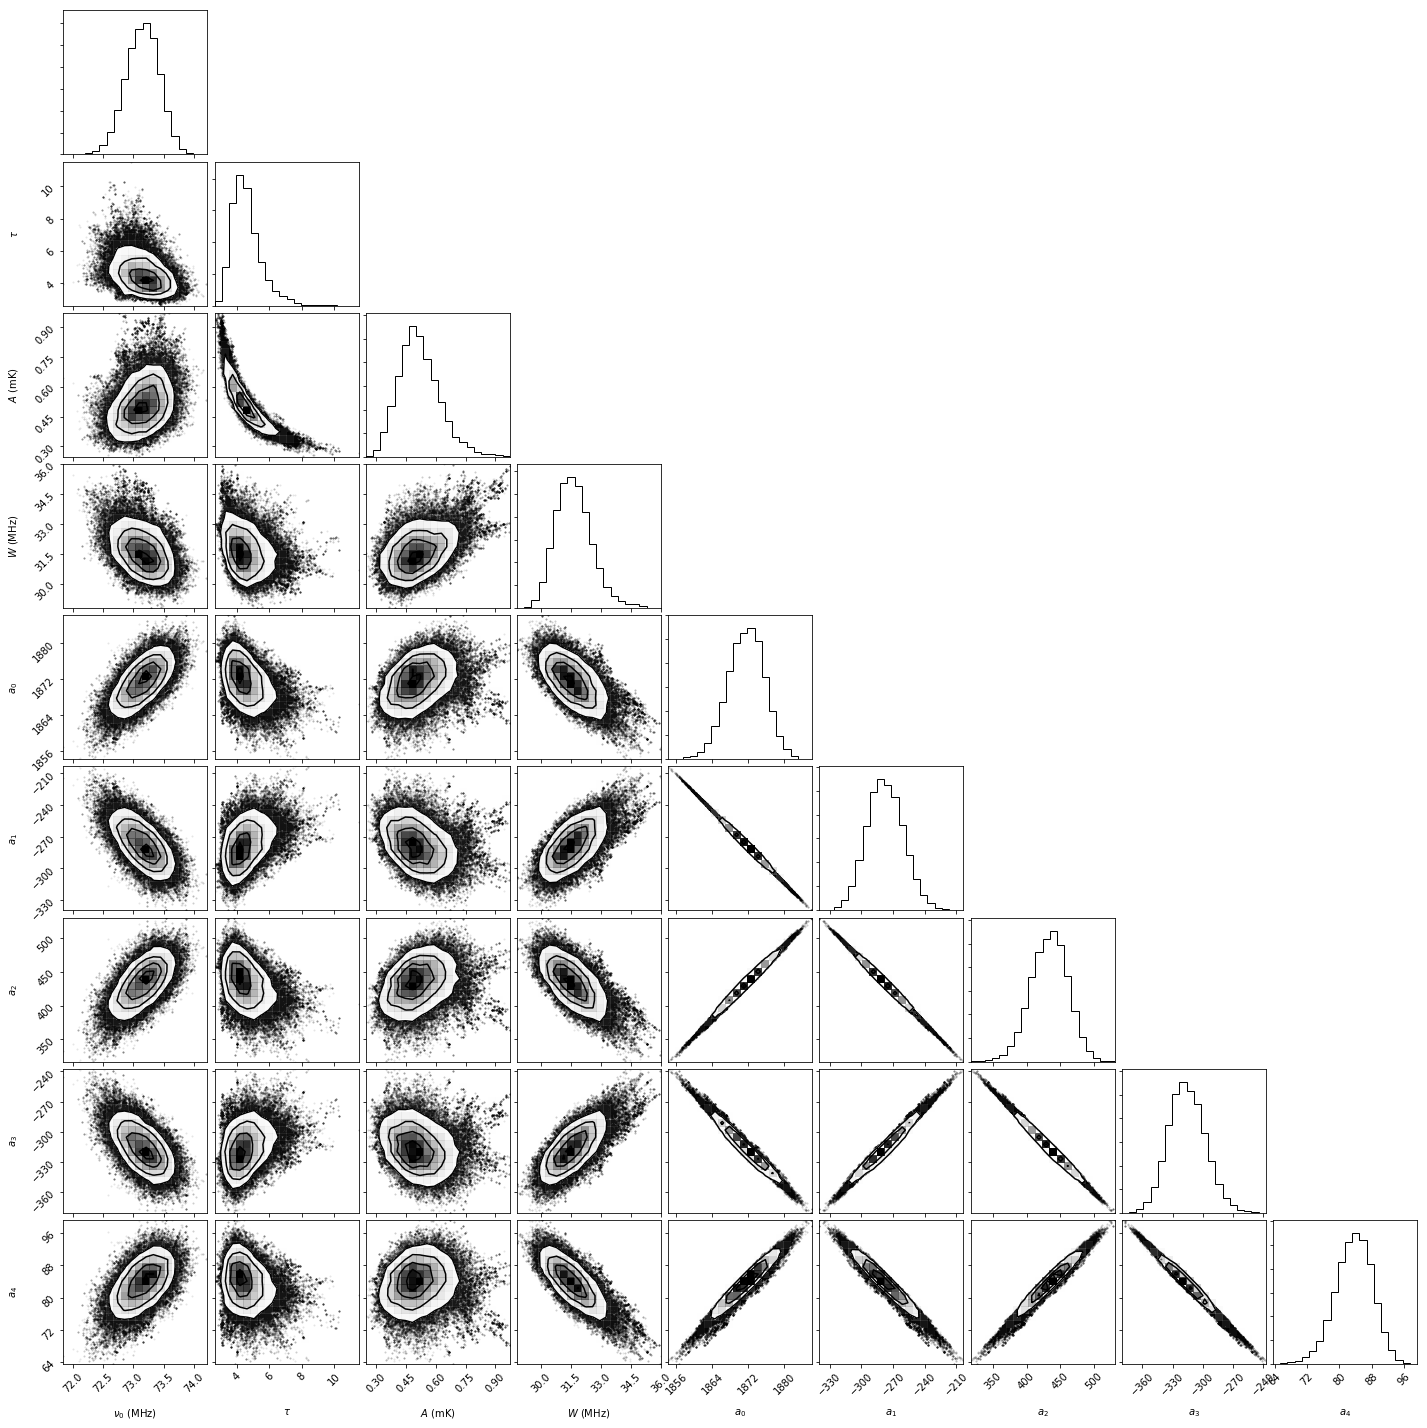

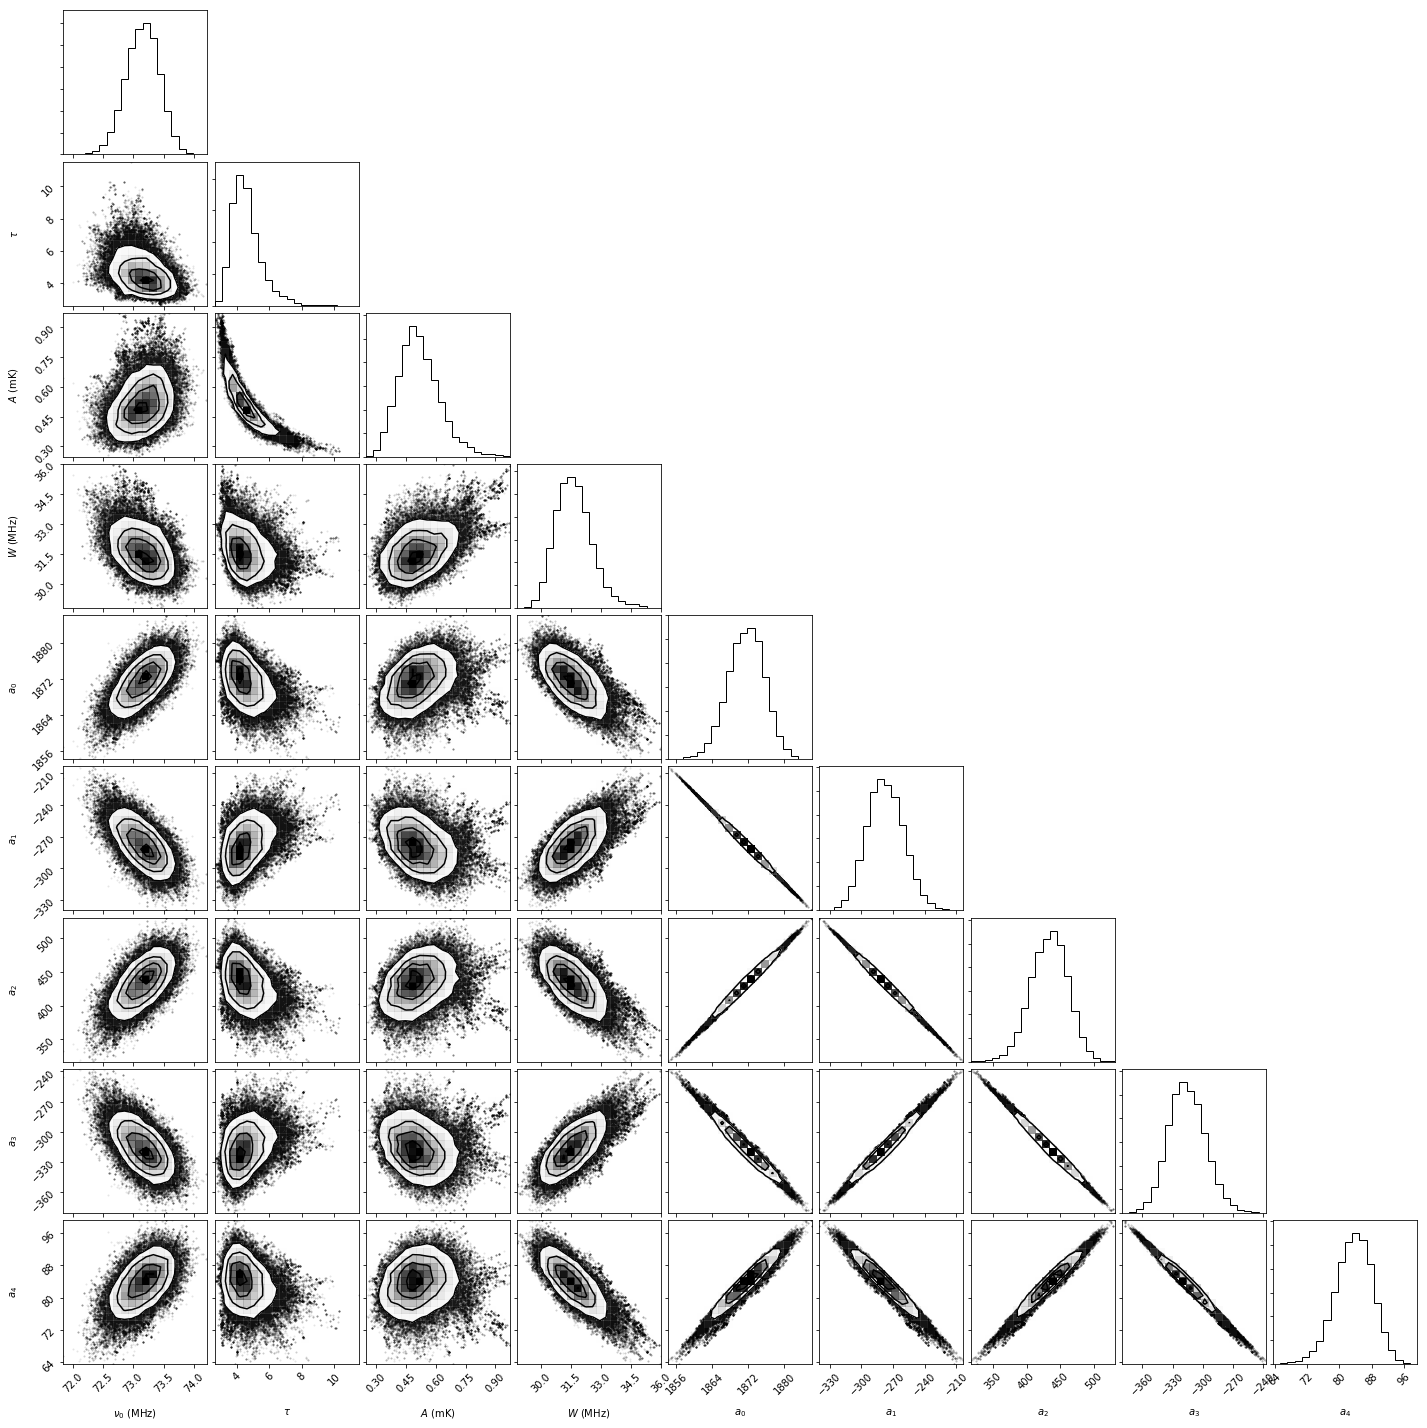

In [4]:
corner.corner(samples,
labels=('$\\nu_0$ (MHz)','$\\tau$','$A$ (mK)','$W$ (MHz)','$a_0$','$a_1$','$a_2$','$a_3$','$a_4$'))

Now we plot the fitted model and our injected model. Clearly the fitted model is very different from our injected signal. Our injected signal had a large amplitude though (thanks to including our black holes) so while its clear that the flatness and specific trough location are artifacts of the fitting model, it is still unclear whether the EDGES fitting technique is also producing the large amplitude. To investigate this, we should inject a model with more reasonable absorption amplitude. 

In [5]:
print(sampler.params_all)

{'NU0': 73.21865676798339, 'TAU': 4.323004732386623, 'A': 0.5215484623046568, 'W': 31.372511887959703, 'NPOLY': 5, 'APOLY0': 1872.8639303733428, 'APOLY1': -283.650417543293, 'APOLY2': 442.8488611415504, 'APOLY3': -322.24474770655905, 'APOLY4': 85.20432106859397}


In [6]:
sampler.params_all['NPOLY']

5

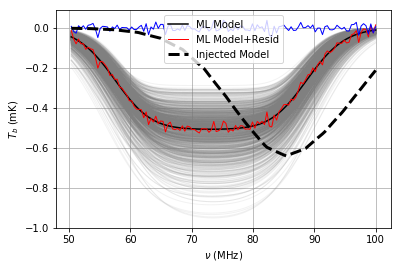

In [7]:
ndraws=1000
for drawnum in range(ndraws):
    draw=np.random.randint(0,len(samples)-1)
    params={'NU0':samples[draw,0],'TAU':samples[draw,1],'A':samples[draw,2],'W':samples[draw,3]}
    plt.plot(sampler.freqs,GSBH_MCMC.delta_Tb_analytic(sampler.freqs,**params),color='grey',lw=1,alpha=.1)
fgdict={}
for n in range(sampler.params_all['NPOLY']):
    key='APOLY%d'%n
    fgdict[key]=ml_samples[n+4] 
fgdict['NPOLY']=sampler.params_all['NPOLY']
l1=plt.plot(sampler.freqs,GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
            sampler.params_all,sampler.params_vary,sampler.analytic)\
        -GSBH_MCMC.Tbfg(sampler.freqs,fgdict),color='k')[0]
l2=plt.plot(sampler.freqs,GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
            sampler.params_all,sampler.params_vary,sampler.analytic)\
        -GSBH_MCMC.Tbfg(sampler.freqs,fgdict)+sampler.dtb,color='r',lw=1)[0]
l3=plt.plot(sampler.freqs,sampler.tb_meas-GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
sampler.params_all,[],sampler.analytic),color='blue',lw=1)[0]
#l3=plt.plot(sampler.freqs,sampler.resid,color='blue',lw=1)[0]
l4=plt.plot(sampler.freqs,sampler.data[:,-2],color='k',ls='--',lw=3)[0]
#plt.ylim(-.6,.1)
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('$T_b$ (mK)')
plt.legend((l1,l2,l4),('ML Model','ML Model+Resid','Injected Model'))
plt.grid()

Now I Perform the same procedure but for a more "canonical" stellar model. The detected signature is very large even though the injected signal is small. I conclude, with significant dissapointment, that the EDGES feature is an artifact of the author's choice of foreground and signal modeling rather than an actual signal. A much more thorough investigation should be performed with a large number of models. 

{'NU0': 78.3216756395833, 'TAU': 7.114613563954874, 'A': 0.43705053910525854, 'W': 20.06951780642346, 'NPOLY': 5, 'APOLY0': 1597.2436461039106, 'APOLY1': 351.8908659734458, 'APOLY2': -583.7822866509799, 'APOLY3': 305.1320691545766, 'APOLY4': -53.74354706941048}


/Users/ewallwic/miniconda2/envs/blackhole_fitting/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


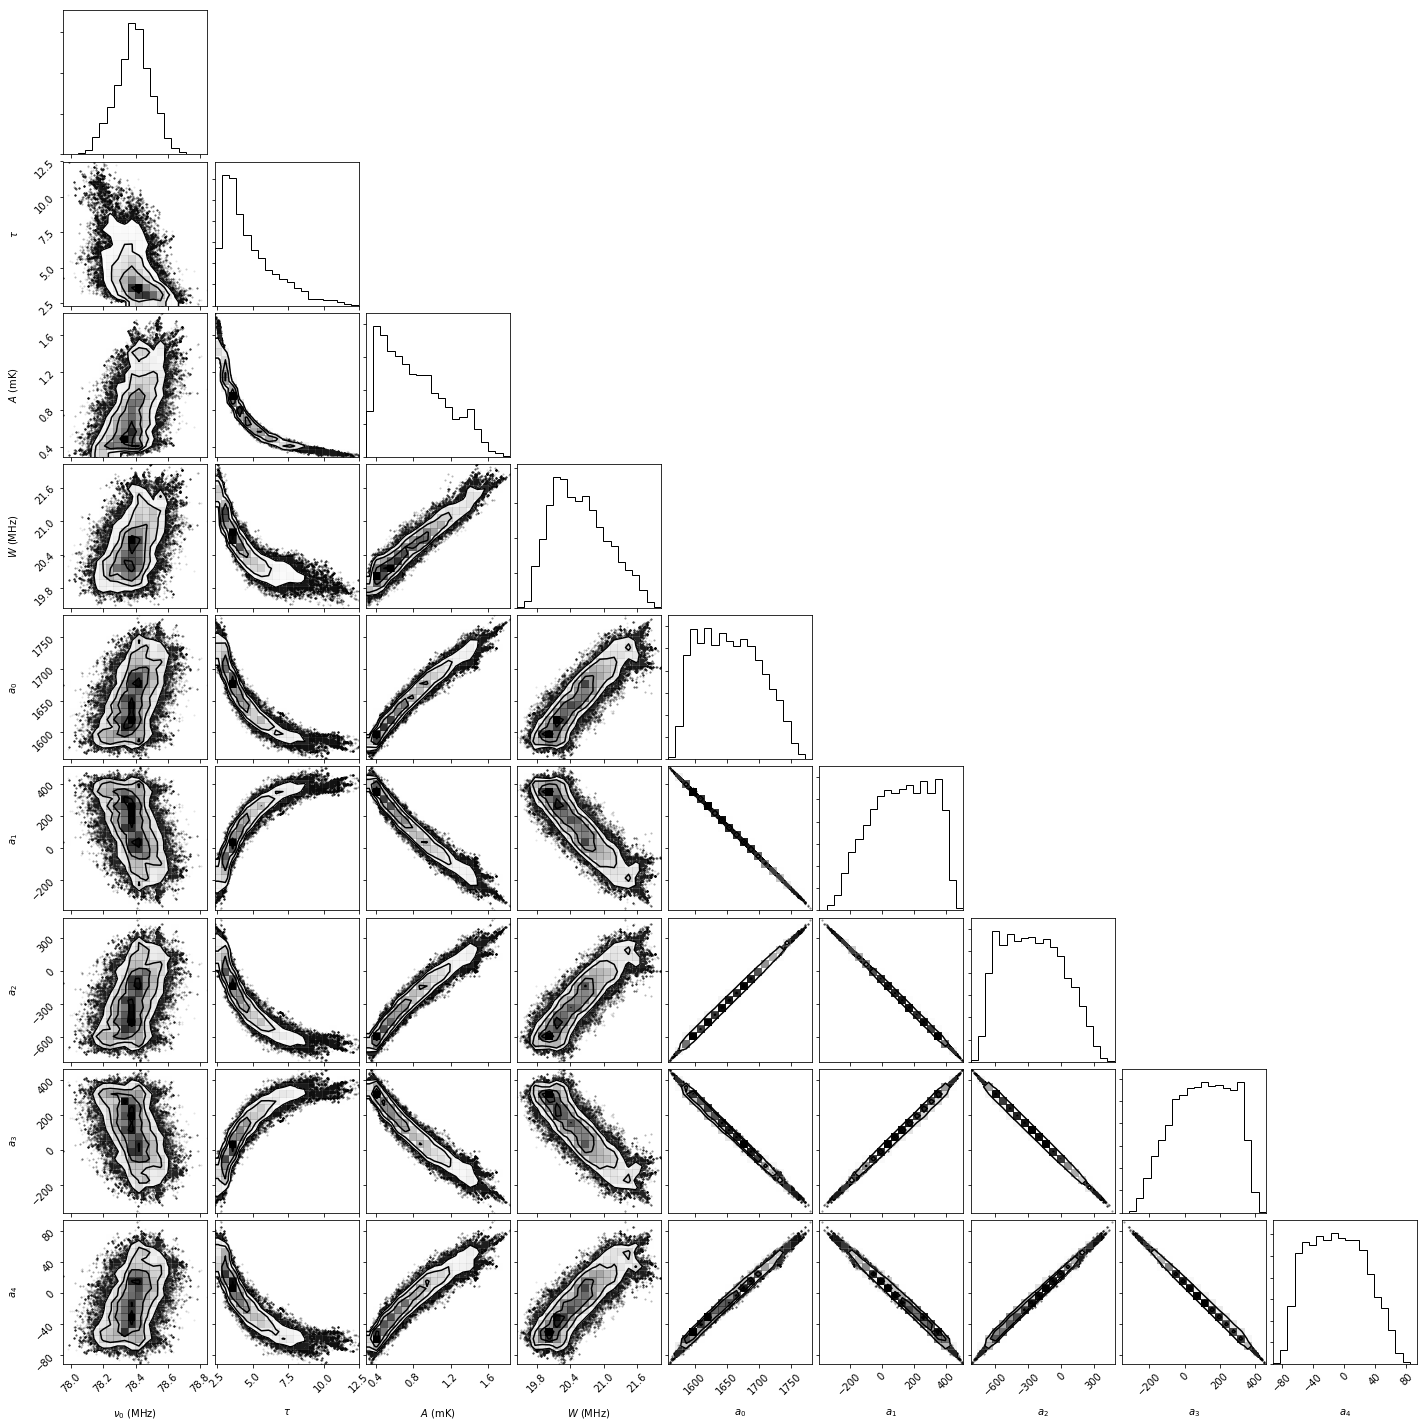

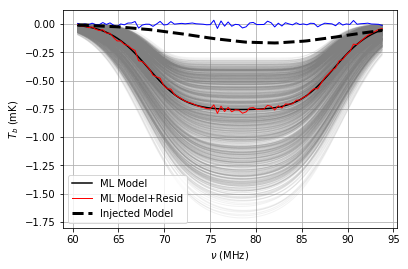

In [8]:
CONFIG='../config/analytic_test_stellar_injection.yaml'
sampler=GSBH_MCMC.Sampler(CONFIG,fmin=50.,fmax=100.)
sampler.sample()
samples=sampler.sampler.chain[:, sampler.config['NBURN']:, :].reshape((-1, len(sampler.params_vary)))
ml_samples=np.median(samples,axis=0)
corner.corner(samples,
labels=('$\\nu_0$ (MHz)','$\\tau$','$A$ (mK)','$W$ (MHz)','$a_0$','$a_1$','$a_2$','$a_3$','$a_4$'))
plt.show()
ndraws=1000
for drawnum in range(ndraws):
    draw=np.random.randint(0,len(samples)-1)
    params={'NU0':samples[draw,0],'TAU':samples[draw,1],'A':samples[draw,2],'W':samples[draw,3]}
    plt.plot(sampler.freqs,GSBH_MCMC.delta_Tb_analytic(sampler.freqs,**params),color='grey',lw=1,alpha=.1)
fgdict={}
for n in range(sampler.params_all['NPOLY']):
    key='APOLY%d'%n
    fgdict[key]=ml_samples[n+4] 
fgdict['NPOLY']=sampler.params_all['NPOLY']
l1=plt.plot(sampler.freqs,GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
            sampler.params_all,sampler.params_vary,sampler.analytic)\
        -GSBH_MCMC.Tbfg(sampler.freqs,fgdict),color='k')[0]
l2=plt.plot(sampler.freqs,GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
            sampler.params_all,sampler.params_vary,sampler.analytic)\
        -GSBH_MCMC.Tbfg(sampler.freqs,fgdict)+sampler.dtb,color='r',lw=1)[0]
l3=plt.plot(sampler.freqs,sampler.tb_meas-GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
sampler.params_all,[],sampler.analytic),color='blue',lw=1)[0]
#l3=plt.plot(sampler.freqs,sampler.resid,color='blue',lw=1)[0]
l4=plt.plot(sampler.freqs,sampler.data[:,-2],color='k',ls='--',lw=3)[0]
#plt.ylim(-.6,.1)
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('$T_b$ (mK)')
plt.legend((l1,l2,l4),('ML Model','ML Model+Resid','Injected Model'))
plt.grid()